In [2]:
import tweetdf
import geopandas
import pandas
import trips
import odm
import sampers
import matplotlib.pyplot as plt
import matplotlib as mpl
import partition
import numpy as np
import odm_similarity
from shapely.geometry import Point
import importlib
importlib.reload(partition)
importlib.reload(odm_similarity)

<module 'odm_similarity' from '/Users/kristofferek/Documents/git/mscthesis/src/py/odm_similarity.py'>

In [1]:
region = 'east'
beta = 0.03

# Partition tweets into Samper's grid system

In this notebook we extract displacements from tweets in a region, and construct an ODM based on the grids used by Samper's model.

In [4]:
tweets = tweetdf.from_csv("./../../dbs/Sweden.csv")
tweets.shape

(1302359, 9)

1,3 Million geotagged tweets (by users with a detected home location in Sweden)

In [19]:
tweets = tweets.dropna()
tweets.shape

(1302358, 9)

## Extract displacements
Currently, we consider two consecutive stays to be a displacement if and only if the time between them is less than 12 hours.

In [6]:
displacements = trips.from_dfs(tweets)
displacements.shape

(554716, 10)

Construct ODM without aggregation into zones (based on lat/long)

In [7]:
latlngodm = odm.from_trips(displacements)
latlngodm.head()

,latitude_o,longitude_o,latitude_d,longitude_d,count
0,-79.898133,-49.192753,59.350000,18.066667,1
1,-54.809017,-68.302105,-54.808049,-68.307551,1
2,-54.808219,-68.318154,-54.809017,-68.302105,1
3,-54.808049,-68.307551,-54.783803,-68.259351,1
4,-54.805765,-68.307080,-54.783803,-68.259351,1


In [8]:
shp = sampers.read_shp(sampers.shps[region])
shp.crs

<Projected CRS: EPSG:3006>
Name: SWEREF99 TM
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Sweden
- bounds: (10.03, 54.96, 24.17, 69.07)
Coordinate Operation:
- name: SWEREF99 TM
- method: Transverse Mercator
Datum: SWEREF99
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

The above dataset defines the zones used by Samper's model.

Low resolution shape of sweden.

In [9]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
sweden = countries[countries.name == "Sweden"]

## ODM construction
Aggregate displacements into origin and destination zones from Samper's model.

In [10]:
odm_twitter_df = partition.convert_to_zones(latlngodm, sweden, shp)
odm_twitter_df

,ozone,dzone,count
0,700611,700611,3963
1,700611,700612,14
2,700611,700613,111
3,700611,700614,146
4,700611,700715,9
...,...,...,...
48608,991844,991831,1
48609,991844,991833,3
48610,991844,991842,20
48611,991844,991843,4


In [11]:
zones_to_index = odm_similarity.shape_to_zone_dictionary(shp)

### Convert dataframe to OD matrix

In [12]:
odm_twitter_mat = odm_similarity.od_df_to_od_matrix(odm_twitter_df, zones_to_index, 'count')
odm_twitter_mat.shape

(3038, 3038)

### Load data from Samper's and place in OD matrix.

In [13]:
odm_sampers_df = sampers.read_odm(sampers.odms[region])
odm_sampers_mat = odm_similarity.od_df_to_od_matrix(odm_sampers_df, zones_to_index, 'total')
odm_sampers_mat.shape

(3038, 3038)

## Plot OD matrices

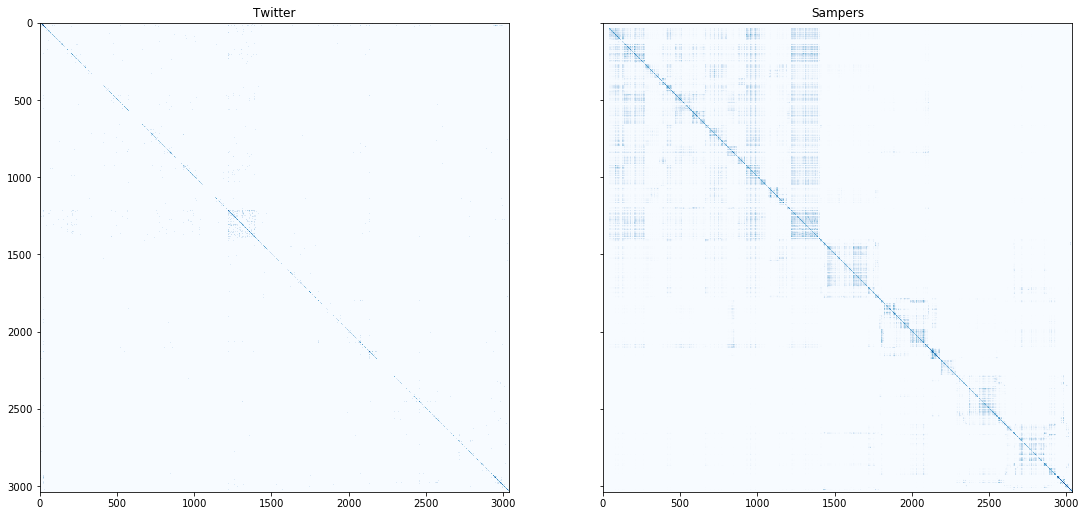

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(odm_twitter_mat, norm = mpl.colors.SymLogNorm(1, vmin=0, vmax=np.max(odm_twitter_mat)), cmap='Blues')
ax2.imshow(odm_sampers_mat, norm = mpl.colors.SymLogNorm(1, vmin=0, vmax=np.max(odm_sampers_mat)), cmap='Blues')
ax1.set_title('Twitter')
ax2.set_title('Sampers')
plt.show()

In [ ]:
OD_gt, OD_tw, W, bins, hist, C1, C2 = odm_similarity.similarity(odm_sampers_df, odm_twitter_df, shp, region)

In [ ]:
SpSSIM_mean, SpSSIM_share_mean, df_comp = odm_similarity.OD2simi(OD_gt, OD_tw, W, bins, hist, C1, C2)
print("Similarity:", SpSSIM_mean, "Similarity weighted by travel demand:", SpSSIM_share_mean)
print("Similarity by distance group:\n", df_comp)

In [17]:
importlib.reload(odm_similarity)
spssim_mean, spssim_share_mean, df_comp, OD_gt, OD_tw = odm_similarity.similarity(odm_sampers_df, odm_twitter_df, shp, region)

DONE: gravity model DF
DONE: gravity DF -> Matrix
DONE: GT DF -> Matrix
        ozone   dzone  count           d
0      700611  700611   3963    0.000000
1      700611  700612     14   44.988908
2      700611  700613    111   52.858434
3      700611  700614    146   58.851359
4      700611  700715      9  109.020791
...       ...     ...    ...         ...
48608  991844  991831      1   79.472609
48609  991844  991833      3   80.101160
48610  991844  991842     20   22.103201
48611  991844  991843      4   21.492041
48612  991844  991844    162    0.000000

[48613 rows x 4 columns]
DONE: Add distances to gravity DF
DONE: bins for SpSSIM created
DONE: Normalize GT matrix
DONE: Normalize Gravity matrix


ZeroDivisionError: division by zero

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(OD_tw, norm = mpl.colors.LogNorm())
ax2.imshow(OD_gt, norm = mpl.colors.LogNorm())
ax1.set_title('Twitter')
ax2.set_title('Sampers')
plt.show()